# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sn
from statsmodels.formula.api import ols

# Prep Data

In [2]:
# import data into local dataframes 
filepath = '../data/data-case.xlsx'
df_users = pd.read_excel(filepath, sheet_name='users')
df_nps = pd.read_excel(filepath, sheet_name='nps')
df_appts = pd.read_excel(filepath, sheet_name='appointments')

# visualize dataframes
df_users.head()

# uncomment and run last to visualize
# df_nps.head()
# df_appts.head()

,user_id,gender,birth_date,start_date,end_date,city_code
0,1,female,1981-07-07,2010-06-29,2010-11-02,3
1,2,male,1996-10-08,2011-01-18,2012-02-18,1
2,3,female,1986-06-03,2010-01-13,2010-09-12,3
3,4,male,1992-07-28,2010-11-19,2012-08-01,3
4,5,male,1981-04-21,2011-08-27,2011-12-11,2


In [3]:
""" Extend `df_users` by adding the total number days a user has been a client.
    This is the variable we care about. 
    
    num_days = end_date - start_date, end date inclusive
"""
df_users['num_days'] = df_users['end_date'] - df_users['start_date']
df_users['num_days'] = df_users['num_days'].dt.days
df_users.head()

,user_id,gender,birth_date,start_date,end_date,city_code,num_days
0,1,female,1981-07-07,2010-06-29,2010-11-02,3,126
1,2,male,1996-10-08,2011-01-18,2012-02-18,1,396
2,3,female,1986-06-03,2010-01-13,2010-09-12,3,242
3,4,male,1992-07-28,2010-11-19,2012-08-01,3,621
4,5,male,1981-04-21,2011-08-27,2011-12-11,2,106


Text(0.5, 1.0, 'Distribution of days over the entire dataset')

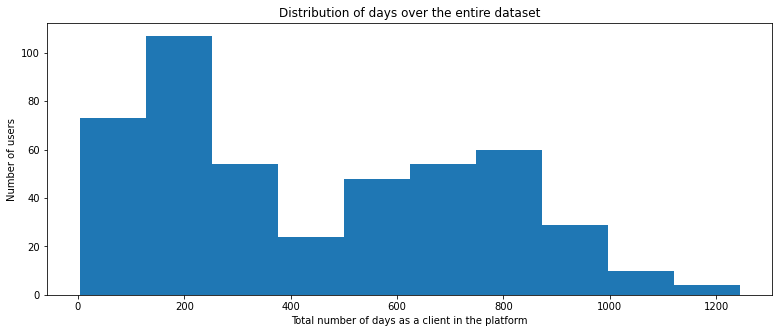

In [4]:
# Visualize distribution of days spent in the platform
plt.figure(figsize=(13,5))
ax = df_users['num_days'].plot.hist()

# Set common labels
ax.set_xlabel('Total number of days as a client in the platform')
ax.set_ylabel('Number of users')
ax.set_title('Distribution of days over the entire dataset')

# Simple and Multiple Linear Regression

In [5]:
df_reg = df_nps.copy() # deep copy to preserve original dataset unchanged

# Extend df_reg by adding three extra variables
df_reg['gender'] = df_users['gender']
df_reg['city_code'] = df_users['city_code']
df_reg['num_days'] = df_users['num_days']

X = df_reg 
X.head()

,user_id,nps,gender,city_code,num_days
0,1,9,female,3,126
1,2,5,male,1,396
2,3,5,female,3,242
3,4,10,male,3,621
4,5,8,male,2,106


In [6]:
""" Multiple linear regression over selected variables.
    Dependent variable: `num_days`, total number of days as a client
    Independent variables: `gender` and `city_code`
"""
model = ols('num_days ~ C(gender) + C(city_code)', data=X)
fitted_model = model.fit()

# print summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_days   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6832
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.686
Time:                        04:45:48   Log-Likelihood:                -3299.9
No. Observations:                 463   AIC:                             6616.
Df Residuals:                     455   BIC:                             6649.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           513.7285    215.439      2.385      0.018      90.349     937.108
C(gender)[T.male]    34.5429     29.355      1.177      0.240     -23.145      92.231
C(city_code)[T.1]   -31.8652    224.133     -0.142      0.887    -472.330     408.600
C(city_code)[T.2]   -87.8859    216.965     -0.405      0.686    -514.264     338.492
C(city_code)[T.3]   -91.6413    216.143     -0.424      0.672    -516.404     333.121
C(city_code)[T.4]   -72.1460    216.742     -0.333      0.739    -498.086     353.794
C(city_code)[T.5]  -173.3468    224.532     -0.772      0.440    -614.595     267.901
C(city_code)[T.6]  -203.4238    277.528     -0.733      0.464    -748.819     341.971
==============================================================================
Omnibus:                      181.610   Durbin-Watson:                   3.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.355
Skew:                           0.345   Prob(JB):                     5.72e-08
Kurtosis:                       1.880   Cond. No.                         53.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

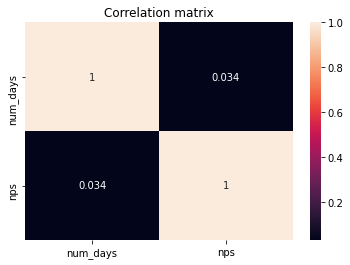

In [7]:
# print correlation matrix for continuous variables
data = {'num_days': X['num_days'],
        'nps': X['nps'],
       }

df = pd.DataFrame(data, columns=['num_days','nps'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation matrix')
plt.show()

# Alternative target variable: total number of appointments

In [8]:
df = df_appts.copy() # deep copy to preserve original dataset unchanged
df = df.groupby('user_id', as_index=False).count() # number of appointments is simply a count of rows
df = df.drop(columns=['appt_id', 'appointment_date', 'channel'])
df = df.rename(columns={"type": "num_appts"}) # pick a colum to rename
df_reg['num_appts'] = df['num_appts']

X = df_reg
X.head()

,user_id,nps,gender,city_code,num_days,num_appts
0,1,9,female,3,126,2
1,2,5,male,1,396,7
2,3,5,female,3,242,4
3,4,10,male,3,621,8
4,5,8,male,2,106,1


In [9]:
""" Multiple linear regression over selected variables.
    Dependent variable: `num_appts`, total number of appts as a client
    Independent variables: `gender` and `city_code`
"""

model = ols('num_appts ~ C(gender) + C(city_code)', data=X)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_appts   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7198
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.655
Time:                        04:45:48   Log-Likelihood:                -1295.5
No. Observations:                 463   AIC:                             2607.
Df Residuals:                     455   BIC:                             2640.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.7714      2.839      2.385      0.017       1.191      12.351
C(gender)[T.male]     0.4572      0.387      1.182      0.238      -0.303       1.218
C(city_code)[T.1]    -0.5478      2.954     -0.185      0.853      -6.353       5.257
C(city_code)[T.2]    -1.2964      2.859     -0.453      0.650      -6.916       4.323
C(city_code)[T.3]    -1.3211      2.849     -0.464      0.643      -6.919       4.277
C(city_code)[T.4]    -1.0041      2.857     -0.351      0.725      -6.618       4.610
C(city_code)[T.5]    -2.4714      2.959     -0.835      0.404      -8.287       3.344
C(city_code)[T.6]    -2.4095      3.658     -0.659      0.510      -9.598       4.778
==============================================================================
Omnibus:                       87.380   Durbin-Watson:                   3.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.327
Skew:                           0.366   Prob(JB):                     7.06e-07
Kurtosis:                       2.035   Cond. No.                         53.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

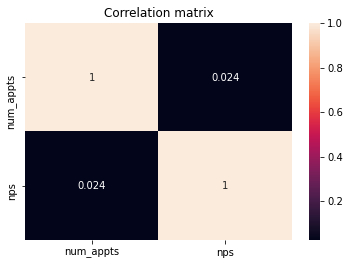

In [10]:
# print correlation matrix for continuous variables
data = {'num_appts': X['num_appts'],
        'nps': X['nps'],
       }

df = pd.DataFrame(data, columns=['num_appts','nps'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation matrix')
plt.show()

# Sanity check n#1: Correlation between num_days and num_appts

In [11]:
model = ols('num_days ~ num_appts', data=X)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_days   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     8551.
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          9.57e-300
Time:                        04:45:49   Log-Likelihood:                -2614.1
No. Observations:                 463   AIC:                             5232.
Df Residuals:                     461   BIC:                             5240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.3373      5.633      3.433      0.001       8.267      30.407
num_appts     73.8888      0.799     92.470      0.000      72.319      75.459
==============================================================================
Omnibus:                       60.231   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.395
Skew:                           0.708   Prob(JB):                     4.84e-29
Kurtosis:                       5.181   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Correlation between number of days and number of appointments')

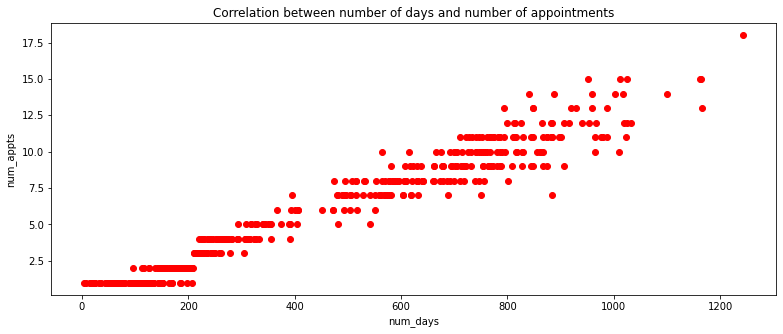

In [13]:
# dot plot
plt.figure(figsize=(13,5))
ax = plt.plot(X['num_days'], X['num_appts'], 'ro')

# Set common labels
plt.xlabel('num_days')
plt.ylabel('num_appts')
plt.title('Correlation between number of days and number of appointments')

# Sanity check n#2: Clustering users based on the last nps

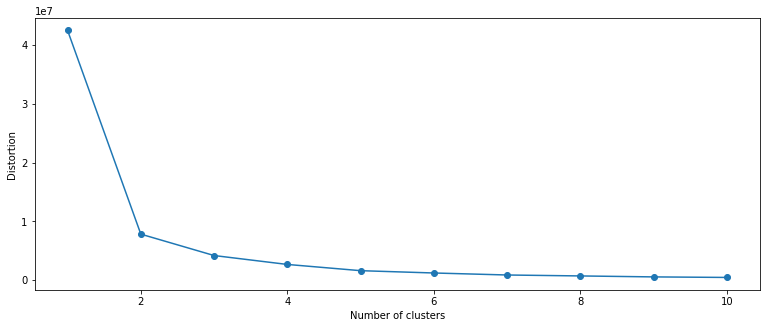

In [16]:
df_k = df_nps.copy() # note to self: df_users has categorical data
df_k['num_days'] = df_users['num_days']
df_k = df_k.drop(columns = ['user_id'])

X = df_k

from sklearn.cluster import KMeans

# calculate distortion for a range of number of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(13,5))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [17]:
# fit model
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

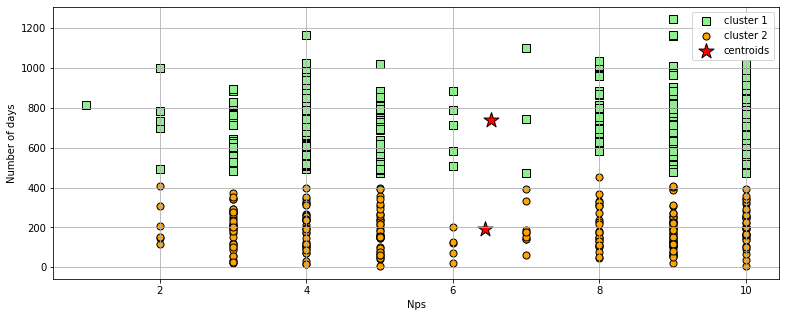

In [22]:
X = np.array(X) 
plt.figure(figsize=(13,5))

# plot the 2 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.xlabel('Nps')
plt.ylabel('Number of days')
plt.show()